# EA-TCA
Applying Euclidean Alignment (EA) and Transfer Component Analysis (TCA) as a transfer learning approach for MI-based BCI.  
This is a master's degree research project at Tohoku University

Author: Orvin Demsy

In [1]:
# Basic
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Additional library
from copy import deepcopy
from csp.utils import subject_counter
from csp.preprocess import fir_bandpass, apply_bandpass, fetch_left_right_EEG
from csp.preprocess import split_EEG_one_class, process_s_data
from csp.feat_extraction import compute_Z, feat_vector, true_label
from csp.csp import CSP

# Set float number print options
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
dframe = pd.DataFrame

In [2]:
# First import the data

# Number of subject, n + 1 for iteration purpose (there are 9 subjects)
ns = 10

# Creating dict to store original data and modified data
# ori_data will serve as initial loaded data that will remain unchanged
ori_data = dict()
mod_data = dict() 

## Load Dataset

In [3]:
import os

# Iter over all data path then store them in sub0X variable
for subj in range(1, 10):
    # Path where BCI data are stored
    path = '..\..\datasets\BCICIV2a'
    file = 'A{:02d}T.npz'.format(subj)
    data_path = os.path.join(path, file)
    
    # Load EEG data from datapath and store into subj0X variabel then store into ori_dict
    # Then also fetch 's' (EEG data) into mod_data
    ori_data[subj] = np.load(data_path)
    mod_data[subj] = {}
    mod_data[subj]['s'] = deepcopy(ori_data[subj]['s'])
    mod_data[subj]['etyp'] = deepcopy(ori_data[subj]['etyp'])
    mod_data[subj]['epos'] = deepcopy(ori_data[subj]['epos'])
    
    # Remove last three EOG electrodes
    mod_data[subj]['s'] = np.delete(mod_data[subj]['s'], np.s_[22:], 1)
    
    # Transpose s so that it's in shape of samples x n_electrodes
    mod_data[subj]['s'] = mod_data[subj]['s'].T

In [4]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos'])

## Preprocessing

### Bandpass Filter

In [5]:
from scipy.signal import firwin, freqs, lfilter

In [6]:
# Frequency sampling at 250Hz
fs = 250

## === Bandpass filter 8-30 Hz ====
# Creating coefficient
b = fir_bandpass(51, low=8, high=30, fs=fs)

# Applying filter
for subj in mod_data.keys():
    temp_raw_EEG = mod_data[subj]['s']
    
    assert temp_raw_EEG.shape[0] < temp_raw_EEG.shape[1]
    
    # Storing filtered data in `s_filt`
    mod_data[subj]['s_filt'] = apply_bandpass(temp_raw_EEG, b)

### Convert `n_samp x n_el` -> `n_trials x n_el x n_samp`

In [7]:
# Iterate overall all_data
for subj in mod_data.keys():
    print('Processing for subject', subj)
    mod_data[subj]['epochs'], mod_data[subj]['y'], _ = process_s_data(data=mod_data[subj], eeg_key='s_filt', start_t=0.5, end_t=3.5, fs=250)
    
    # Make sure they are in correct size
    assert mod_data[subj]['epochs'].shape[0] == 144
    assert mod_data[subj]['epochs'].shape[1] == 22
    assert mod_data[subj]['epochs'].shape[2] > 144    

Processing for subject 1
Processing for subject 2
Processing for subject 3
Processing for subject 4
Processing for subject 5
Processing for subject 6
Processing for subject 7
Processing for subject 8
Processing for subject 9


## Apply Euclidean Alignment on raw EEG

In [8]:
from func.EA import apply_EA
from func.csp_matlab import csp_feat_ver1

In [9]:
# Check current keys in single subject
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y'])

In [10]:
%%capture
# Iterate over all subjects to apply EA to all trials
# Define keys to be processed
process_key = ['epochs']

for subj in mod_data.keys():
    print('Processing subject ', subj)
    mod_data[subj]['epochs_EA']  = apply_EA(mod_data[subj], process_key)
    print('')

In [11]:
all_trials = mod_data[1]['epochs']
all_trials.shape

(144, 22, 750)

In [12]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y', 'RefEA', 'R_inv', 'epochs_EA'])

In [13]:
# Sanity check that each subject EA data equal to identity matrix
for subj in mod_data.keys():
    all_trials = mod_data[subj]['epochs_EA']
    all_cov = 0
    
    for tr in all_trials:
        all_cov += np.cov(tr, rowvar=True, ddof=1)
    
    all_cov = all_cov/len(all_trials)
    
    assert np.round(np.diag(all_cov)).sum() == 22
    print('Subject %d Aligned!' %subj)

Subject 1 Aligned!
Subject 2 Aligned!
Subject 3 Aligned!
Subject 4 Aligned!
Subject 5 Aligned!
Subject 6 Aligned!
Subject 7 Aligned!
Subject 8 Aligned!
Subject 9 Aligned!


# Visualizing using T-SNE
Skip visualization

In [14]:
from func.csp_matlab import csp_feat_no_test

In [15]:
mod_data[1].keys()

dict_keys(['s', 'etyp', 'epos', 's_filt', 'epochs', 'y', 'RefEA', 'R_inv', 'epochs_EA'])

In [16]:
# Extract csp features from both epoch without and with EA
data = mod_data

for subj in data.keys():
    # Compute csp feature
    data[subj]['all_feats'] = csp_feat_no_test(data[subj], eeg_key='epochs')
    data[subj]['all_feats_EA'] = csp_feat_no_test(data[subj], eeg_key='epochs_EA')

In [17]:
# Sanity check of shape of csp features
for subj in mod_data.keys():
    assert mod_data[subj]['all_feats'].shape[0] == 144
    assert mod_data[subj]['all_feats_EA'].shape[0] == 144 

# Transfer Learning Case, CSP + TCA

In [18]:
# Re-prepare data, redefine TL_data, delete existing content
TL_data = {}
TL_data['tgt'] = {}
TL_data['src'] = {}

for subj in mod_data.keys():
    # TARGET
    TL_data['tgt'][subj] = {}
    TL_data['tgt'][subj]['epochs']    = deepcopy(mod_data[subj]['epochs'])
    TL_data['tgt'][subj]['epochs_EA'] = deepcopy(mod_data[subj]['epochs_EA'])
    TL_data['tgt'][subj]['all_feats'] = deepcopy(mod_data[subj]['all_feats'])
    TL_data['tgt'][subj]['all_feats_EA'] = deepcopy(mod_data[subj]['all_feats_EA'])
    TL_data['tgt'][subj]['y']            = deepcopy(mod_data[subj]['y'])    
    
    # SOURCE
    TL_data['src'][subj] = {}
    TL_data['src'][subj]['epochs']        = deepcopy(mod_data[subj]['epochs'])
    TL_data['src'][subj]['epochs_EA']     = deepcopy(mod_data[subj]['epochs_EA'])
    TL_data['src'][subj]['all_feats']     = deepcopy(mod_data[subj]['all_feats'])
    TL_data['src'][subj]['all_feats_EA']  = deepcopy(mod_data[subj]['all_feats_EA'])
    TL_data['src'][subj]['y']             = deepcopy(mod_data[subj]['y'])    

In [19]:
TL_data['src'].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

## `MMD`
source: https://github.com/jindongwang/transferlearning/blob/master/code/distance/mmd_numpy_sklearn.py

In [20]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics

def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=1):
    #print('mmd: poly')
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)
    Arguments:a
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()

class MMD():
    def __init__(self, kernel='linear', gamma=1, degree=2, coef=1):
        self.kernel = kernel
        self.gamma  = gamma
        self.degree = degree
        self.coef   = coef
        
    def mmd_dist(self, X, Y):
        if self.kernel   == 'linear':
            return mmd_linear(X, Y)
        elif self.kernel == 'poly':
            return mmd_poly(X, Y, degree=self.degree, gamma=self.gamma, coef0=self.coef)
        elif self.kernel == 'rbf':
            return mmd_rbf(X, Y, gamma=self.gamma)    
        else:
            raise AssertionError('Invalid kernel')

## `TCA`
source: https://github.com/jindongwang/transferlearning/blob/master/code/traditional/TCA/TCA.py

In [21]:
import scipy.linalg
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier

def kernel(ker, X1, X2, degree=3, gamma=1, coef=1):
    K = None
    if not ker or ker == 'primal':
        K = X1
    elif ker == 'linear':
        #print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T, np.asarray(X2).T)
        else:
            K = sklearn.metrics.pairwise.linear_kernel(np.asarray(X1).T)
    elif ker == 'rbf':
        #print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, np.asarray(X2).T, gamma)
        else:
            K = sklearn.metrics.pairwise.rbf_kernel(np.asarray(X1).T, None, gamma)
            
    elif ker == 'poly':
        #print(f'=== {ker} kernel ===')
        if X2 is not None:
            K = sklearn.metrics.pairwise.polynomial_kernel(np.asarray(X1).T, np.asarray(X2).T, degree, gamma, coef)
        else:
            K = sklearn.metrics.pairwise.polynomial_kernel(np.asarray(X1).T, None, degree, gamma, coef)
            
    return K

In [22]:
# === TCA modified from original the following: ===
# - handles incremental target data, + coef
# - degree param
# - with SVM classifier
# - only returned real tca features (complex value may occurs when using linear kernel)

class TCA:
    def __init__(self, kernel_type='primal', dim=30, svm_kernel='rbf', lamb=1, gamma=1, coef=1, degree=3):
        '''
        Init func
        :param kernel_type: kernel, values: 'primal' | 'linear' | 'rbf'
        :param dim: dimension after transfer
        :param lamb: lambda value in equation
        :param gamma: kernel bandwidth for rbf kernel
        '''
        self.kernel_type = kernel_type
        self.svm_kernel = svm_kernel
        self.dim    = dim
        self.lamb   = lamb
        self.gamma  = gamma
        self.coef   = coef
        self.degree = degree
        self.W_proj = None
        self.X_src2 = None
        self.clf = None

    def fit(self, Xs, Xt):
        '''
        Transform Xs and Xt
        :param Xs: ns * n_feature, source feature
        :param Xt: nt * n_feature, target feature
        :return: Xs_new and Xt_new after TCA
        '''
        X = np.hstack((Xs.T, Xt.T))
        X /= np.linalg.norm(X, axis=0)
        m, n = X.shape
        ns, nt = len(Xs), len(Xt)
        e = np.vstack((1 / ns * np.ones((ns, 1)), -1 / nt * np.ones((nt, 1))))
        M = e * e.T
        M = M / np.linalg.norm(M, 'fro')
        H = np.eye(n) - 1 / n * np.ones((n, n))
        
        K = kernel(self.kernel_type, X, None, gamma=self.gamma, coef=self.coef, degree=self.degree)
        
        n_eye = m if self.kernel_type == 'primal' else n
        a, b = np.linalg.multi_dot([K, M, K.T]) + self.lamb * np.eye(n_eye), np.linalg.multi_dot([K, H, K.T])
        w, V = scipy.linalg.eig(a, b)
        ind = np.argsort(w)
        A = V[:, ind[:self.dim]]
        Z = np.dot(A.T, K)
        Z /= np.linalg.norm(Z, axis=0)
        
        # Save projection matrix and X as new source
        self.W_proj  = A
        self.X_src2 = X
        
        Xs_new, Xt_new = Z[:, :ns].T, Z[:, ns:].T
        return Xs_new.real, Xt_new.real

    def fit_predict(self, Xs, Ys, Xt, Yt):
        '''
        Transform Xs and Xt, then make predictions on target using 1NN
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt: nt * n_feature, target feature
        :param Yt: nt * 1, target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        Xs_new, Xt_new = self.fit(Xs, Xt)
        
        # === Train classifier ===
        clf = SVC(kernel=self.svm_kernel, probability=True)
        clf.fit(Xs_new, Ys.ravel())
        y_pred = clf.predict(Xt_new)
        acc = sklearn.metrics.accuracy_score(Yt, y_pred)
        
        # === Save classifier ===
        self.clf = clf
        
        # === F1 score and ROC score ===
        f1_sc  = f1_score(Yt, y_pred)
        #auc_sc = roc_auc_score(Yt, self.clf.predict_proba(Xt_new)[:, 1])
        auc_sc = roc_auc_score(Yt, self.clf.decision_function(Xt_new))
        
        return acc, y_pred, f1_sc, auc_sc

    def fit_new(self, Xt2):
        '''
        Map Xt2 to the latent space created from Xt and Xs in .fit
        Using existing W_proj and X_src2
        :param Xs : ns * n_feature, source feature
        :param Xt : nt * n_feature, target feature
        :param Xt2: n_s, n_feature, target feature to be mapped
        :return: Xt2_new, mapped Xt2 with projection created by Xs and Xt
        '''
        if not np.all(self.W_proj):
            raise AssertionError('No projection matrix found, use .fit to find projectino matrix, feature of source and target')
        
        # Reshape to make it consistent with other methods
        Xt2 = Xt2.T

        # Compute kernel with respect to self.X_new_src
        K = kernel(self.kernel_type, X1 = Xt2, X2 = self.X_src2, gamma=self.gamma)

        # New target features
        Xt2_new = K @ self.W_proj

        return Xt2_new.real
    
    def fit_predict_new(self, Xt2, Yt2):
        '''
        Transfrom Xt and Xs, get Xs_new
        Transform Xt2 with projection matrix created by Xs and Xt, get Xt2_new
        Make predictions on Xt2_new using classifier trained on Xs_new
        :param Xt: ns * n_feature, target feature
        :param Xs: ns * n_feature, source feature
        :param Ys: ns * 1, source label
        :param Xt2: nt * n_feature, new target feature
        :param Yt2: nt * 1, new target label
        :return: Accuracy and predicted_labels on the target domain
        '''
        if not np.all(self.W_proj) or not np.all(self.clf) :
            raise AssertionError('No classifier found, trained classifier first using .fit_predict')

        Xt2_new = self.fit_new(Xt2)

        y_pred = self.clf.predict(Xt2_new)
        acc = sklearn.metrics.accuracy_score(Yt2, y_pred)

        # === F1 score and ROC score ===
        f1_sc  = f1_score(Yt2, y_pred)
        #auc_sc = roc_auc_score(Yt2, self.clf.predict_proba(Xt2_new)[:, 1])
        auc_sc = roc_auc_score(Yt2, self.clf.decision_function(Xt2_new))
        
        return acc, y_pred, f1_sc, auc_sc

In [23]:
# Function to convert score and std to +/- form
conv = lambda sc, std: str(f'{np.round(sc, 2):.2f}') + ' +/- ' + str(f'{np.round(std, 3):.2f}')
# print(conv(80.3, 0.5678)) # 80.30 +/- 0.57 

In [24]:
def mmd_to_src(data, tgt_sub, csp_tgt, csp_feat_key, n_sim_sub, dist_meas='mmd_rbf'):
    '''
    Built specifically to handle mi-bci TL case with TCA
    :params:
    data     : data containing csp source data
    csp_tgt  : csp target data againts which distance will be measure
    n_sim_sub: pick n_most similar subj
    
    :return:
    sim_sub  : subject with the least mmd value, ie closest to csp_tgt
    '''
    # ===== Find most similar source to current target data ====== #
    # MMD from csp_tgt to rest of source
    mmd = []
    for src_subj in data['src'].keys():
        if src_subj == tgt_sub:
            mmd.append(0)
        else:
            csp_src = data['src'][src_subj][csp_feat_key]
            mmd.append(mmd_linear(csp_src, csp_tgt))

    # Plus to because index starts from zero
    mmd_sim = np.argsort(np.array(mmd))+1    

    # Choose n_sim most simliar source to current target subject 
    n_sim_subj = mmd_sim[1:n_sim_sub+1] 
    # print(f'sim subj: {n_sim_subj}')
    
    return n_sim_subj

In [25]:
# SVC class just to make it consistent with TCA
class ModelSVM():
    def __init__(self, kernel='rbf', coef=0):
        self.kernel = kernel
        self.coef   = coef
        
        
    def fit_predict(self, Xs, Ys, Xt, Yt):
        # Define classifier
        model_svm = SVC(kernel=self.kernel, coef0=self.coef, probability=True)

        # Fitting data
        model_svm.fit(Xs, Ys)
        ypred = model_svm.predict(Xt)
        acc = metrics.accuracy_score(Yt, ypred)
        
        # === F1 score and ROC score ===
        f1_sc  = f1_score(Yt, ypred)
        #auc_sc = roc_auc_score(Yt, model_svm.predict_proba(Xt)[:, 1])
        auc_sc = roc_auc_score(Yt, model_svm.decision_function(Xt))
        
        return acc, ypred, f1_sc, auc_sc

## `evaluate-all` function 7
**Main idea** :   
Found out about how to do update on incremental data with TCA, this section will include method that handles about that as well.

The following method will be evaluate:
- CSP-SVM
- EA-CSP-SVM
- CSP-TCA-SVM
- EA-CSP-TCA-SVM

**Pseudocode**:
1. Function `eval_all_ver7` will accept the following parameter:
    - data    : data consisting of source and target
    - tgt_subj: subject act as target data
    - model   : model to be evaluated
    - tca_ker : kernel of tca
    - tca_dim : dim of tca
    - svm_ker : kernel of svm
    - n_tgt1  : random n sample of xt1
    - n_tgt2  : random n sample of xt2
    - n_sim   : n similar source to be paired with xt1 or xt2
    - n_src   : random n sample of src
    
    
2. Function `eval_all_ver7` will do the following:
    - Xt_raw   : will choose whether ori or EA-ed data
    - Xt1, Xt2 : random n sample from Xt, stratify Yt
    - csp_xt2 = csp(Xt2, Yt2) and csp_xt1 = csp(Xt1, Yt1)
    - csp_xs of all subjects
    - distance, MMD of csp_xt1 to all csp_xs
    - distance, MMD of csp_xt2 to all csp_xs
    - evaluate specified model

In [26]:
import random
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from func.csp_matlab import csp_feat_no_test_2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [27]:
def eval_all_ver7(data, tgt_subj=1, model='CSP-TCA-SVM', tca_ker='linear',\
                  tca_dim=3, svm_ker='linear', n_tgt1=20, n_tgt2=30, n_sim=3, n_src=144):
    
    print(f'Processing target subject: {tgt_subj}')
    print(f'Model: == {model} ==') 
    
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]
    
    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    ## Following models need to fetch source EA data
    # model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']
    
    # === EA data ====
    if 'EA' in model:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat_key = 'all_feats_EA'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat_key = 'all_feats'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')
    
    # =============== RAW TARGET DATA ============== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])
    
    # ===== N random target1 and target2 sample ==== #
    # == Target 1 ==
    idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    while (y_tgt[idx] == 1).sum() != n_tgt1//2:
        idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    
    # == Target 1 == #
    Xraw_tgt1 = Xraw_tgt[idx]
    y_tgt1    = y_tgt[idx]
    
    Xraw_tgt_left = np.delete(Xraw_tgt, idx, axis=0)
    y_tgt_left    = np.delete(y_tgt, idx, axis=0)
    
    # == Target 2 == #
    idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
    while (y_tgt_left[idx] == 1).sum() != n_tgt2//2:
        idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
        
    Xraw_tgt2 = Xraw_tgt_left[idx]
    y_tgt2    = y_tgt_left[idx]
    
    # == CSP Xraw_tgt1 and Xraw_tgt2 ==
    csp_tgt_self_1 = csp_feat_no_test_2(Xraw_tgt1, y_tgt1, n_filter=3)
    csp_tgt_self_2 = csp_feat_no_test_2(Xraw_tgt2, y_tgt2, n_filter=3)
    
    # == Compute MMD csp_tgt1 and csp_tgt2 ==
    n_sim_sub_tgt1 = mmd_to_src(data, tgt_subj, csp_tgt_self_1, csp_feat_key, n_sim_sub=n_sim)
    n_sim_sub_tgt2 = mmd_to_src(data, tgt_subj, csp_tgt_self_2, csp_feat_key, n_sim_sub=n_sim)    
    
    print(f'MMD result {n_sim} most similar subject to csp_tgt1 of target {tgt_subj} : {n_sim_sub_tgt1}')
    
    # ================== EVALUATION ==================== #
    # Variable to store best score from similar source subject
    temp_acc = []
    temp_f1 = []
    temp_auc= []
    
    # ======= SVM ======= #
    if model == 'Baseline' or model == 'EA-Baseline':
        print(f'Evaluating {model}')
        # Iterate over n similar subjects
        for sim_subj in n_sim_sub_tgt1:
            # =============== RAW SOURCE DATA ============== #
            Xraw_src = deepcopy(data['src'][sim_subj][key])
            y_src    = deepcopy(data['src'][sim_subj]['y'])

            # ===== N random source sample ==== #
            idx = random.sample(range(len(Xraw_src)), n_src)
            while (y_src[idx] == 1).sum() != n_src//2:
                idx = random.sample(range(len(Xraw_src)), n_src)
            Xraw_src = Xraw_src[idx]
            y_src    = y_src[idx]
            
            # === CSP of Xraw_tgt2 with filter from Xraw_src ===
            csp_src, csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
            
            # === Perform SVM ===
            svm             = ModelSVM(kernel=svm_ker)
            acc, _, f1, auc = svm.fit_predict(csp_src, y_src, csp_tgt2, y_tgt2)
            
            # === Append score, f1, and roc ===
            temp_acc.append(acc)
            temp_f1.append(f1)
            temp_auc.append(auc)
            
            # === Find best score, and corresponding f1 and roc ===
            best_idx = temp_acc.index(max(temp_acc))
            best_acc = temp_acc[best_idx]*100
            best_f1  = temp_f1[best_idx]*100
            best_auc = temp_auc[best_idx]*100
    
    # ==== TCA ==== # 
    if model == 'TCA' or model == 'EA-TCA':
        print(f'Evaluating {model}')
        # Iterate over n similar subjects
        for sim_subj in n_sim_sub_tgt1:
            # =============== RAW SOURCE DATA ============== #
            Xraw_src = deepcopy(data['src'][sim_subj][key])
            y_src    = deepcopy(data['src'][sim_subj]['y'])

            # ===== N random source sample ==== #
            idx = random.sample(range(len(Xraw_src)), n_src)
            while (y_src[idx] == 1).sum() != n_src//2:
                idx = random.sample(range(len(Xraw_src)), n_src)

            Xraw_src = Xraw_src[idx]
            y_src    = y_src[idx] 

            # === CSP of Xraw_tgt2 with filter from Xraw_src ===
            csp_src, csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
            
            # === Perform TCA ===
            tca             = TCA(kernel_type=tca_ker, dim=tca_dim, svm_kernel=svm_ker, lamb=1, gamma=1, coef=1, degree=3)
            acc, _, f1, auc = tca.fit_predict(csp_src, y_src, csp_tgt2, y_tgt2)
            
            # === Append score, f1, and roc ===
            temp_acc.append(acc)
            temp_f1.append(f1)
            temp_auc.append(auc)
            
            # === Find best score, and corresponding f1 and roc ===
            best_idx = temp_acc.index(max(temp_acc))
            best_acc = temp_acc[best_idx]*100
            best_f1  = temp_f1[best_idx]*100
            best_auc = temp_auc[best_idx]*100
    
    # ==== TCA-W ==== # 
    if model == 'TCA-W' or model == 'EA-TCA-W':
        print(f'Evaluating {model}')
        # Iterate over n similar subjects
        for sim_subj in n_sim_sub_tgt1:
            # =============== RAW SOURCE DATA ============== #
            Xraw_src = deepcopy(data['src'][sim_subj][key])
            y_src    = deepcopy(data['src'][sim_subj]['y'])

            # ===== N random source sample ==== #
            idx = random.sample(range(len(Xraw_src)), n_src)
            while (y_src[idx] == 1).sum() != n_src//2:
                idx = random.sample(range(len(Xraw_src)), n_src)

            Xraw_src = Xraw_src[idx]
            y_src    = y_src[idx] 
            
            # CSP of Xraw_tgt1 and Xraw_tgt2 with filter from Xraw_src 
            csp_src, csp_tgt1 = csp_feat_ver1(Xraw_src, Xraw_tgt1, y_src, n_filter=3)
            _      , csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
            
            # !! NOTICE csp_tgt1 is only to build W and clf in tca.fit_predict !!
            tca             = TCA(kernel_type=tca_ker, dim=tca_dim, svm_kernel=svm_ker, lamb=1, gamma=1, coef=1, degree=3)
            _, _, _, _      = tca.fit_predict(csp_src, y_src, csp_tgt1, y_tgt1)
            acc, _, f1, auc = tca.fit_predict_new(csp_tgt2, y_tgt2)

            # === Append score, f1, and roc ===
            temp_acc.append(acc)
            temp_f1.append(f1)
            temp_auc.append(auc)
            
            # === Find best score, and corresponding f1 and roc ===
            best_idx = temp_acc.index(max(temp_acc))
            best_acc = temp_acc[best_idx]*100
            best_f1  = temp_f1[best_idx]*100
            best_auc = temp_auc[best_idx]*100

    print('')
    print(f'All accuracy: {temp_acc}')
    print(f'All F1-score: {temp_f1}')
    print(f'All roc auc : {temp_auc}')
    print(f'Best accuracy score: {best_acc:.3f}, F1 score: {best_f1:.3f}, ROC_AUC score: {best_auc:.3f}')
    
    return best_acc, best_f1, best_auc

In [115]:
%%capture
# ==================== EVALUATION ====================== #
# ==== Proposed case using only 10 source data (prop: proposed) =====
models = ['Baseline', 'EA-Baseline', 'TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']
# models = ['EA-TCA-W']
data = TL_data
n_iter = 20
prop_acc7 = {}
prop_f17  = {}
prop_auc7 = {}

# Iterate over each model, each subject as target
for m in models:
    prop_acc7[m] = {}
    prop_f17[m]  = {}
    prop_auc7[m] = {}
    
    for t in data['tgt'].keys():
        prop_acc7[m][t] = []
        prop_f17[m][t]  = []
        prop_auc7[m][t] = []
    
        for i in range(n_iter):
            print(f'Iteration {i+1}')
            acc, f1, auc = eval_all_ver7(data, tgt_subj=t, model=m, tca_ker='rbf', \
                               tca_dim=4, svm_ker='linear', n_tgt1=30, n_tgt2=50, n_sim=3, n_src=30)
            
            
            prop_acc7[m][t].append(acc)
            prop_f17[m][t].append(f1)
            prop_auc7[m][t].append(auc)            

In [116]:
# ========= Create df for proposed case ======== #
# Columns are method whose value are scores of all subject === #
df_prop_acc7 = pd.DataFrame([])

# Iterate over all methods
for m in prop_acc7.keys():
    temp = pd.DataFrame(prop_acc7[m])
    temp = temp.melt(value_vars=[1, 2, 3, 4, 5, 6, 7, 8, 9], value_name=m, var_name='subject', ignore_index=False)
    temp.index.name='iter'
    
    df_prop_acc7 = pd.concat([df_prop_acc7, temp[[m]]], axis=1) if 'subject' in df_prop_acc7.columns else pd.concat([df_prop_acc7, temp], axis=1) 

df_prop_acc7.columns.name='methods'
# df_prop_sc7.drop(labels='subject',axis=1, inplace=True)
print(f'Length of data is n_subj(9)*n_iter({n_iter}): {len(df_prop_acc7)}')
df_prop_acc7.head()

Length of data is n_subj(9)*n_iter(20): 180


methods,subject,Baseline,EA-Baseline,TCA,EA-TCA,TCA-W,EA-TCA-W
iter,,,,,,,
0,1,54.0,88.0,68.0,88.0,66.0,56.0
1,1,68.0,64.0,66.0,66.0,70.0,94.0
2,1,72.0,90.0,86.0,58.0,52.0,84.0
3,1,58.0,86.0,68.0,84.0,62.0,80.0
4,1,68.0,82.0,62.0,72.0,60.0,88.0


In [28]:
# ===== Save df_prop_sc7 to Excel ====== #
# 20210410 save current df_prop_sc7 to excel
fname = 'df_prop_acc7.xlsx'
fpath = os.path.join('excel', fname)

if not os.path.isfile(fpath):
    print(f'saving {fname} ...')
    df_prop_acc7.to_excel(fname, index=True, header=True)
else:
    print(f'{fname} already exist')

df_prop_acc7.xlsx already exist


In [28]:
# ===== Load df_prop_sc7 ===== #
df_prop_acc7 = pd.read_excel('excel/df_prop_acc7.xlsx', index_col=0)

In [29]:
# ==== Average score per subject in df_prop_sc7 ==== #
df_avg_acc7 = pd.DataFrame([])
for t in df_prop_acc7['subject'].unique():
    temp = pd.DataFrame(df_prop_acc7[df_prop_acc7['subject'] == t].mean()).T
    temp['subject'] = temp['subject'].astype(int)
    df_avg_acc7 = pd.concat([df_avg_acc7, temp], axis=0)
    
df_avg_acc7 = df_avg_acc7.set_index('subject')
df_avg_acc7.loc['avg'] = df_avg_acc7.mean()
df_avg_acc7.loc['std'] = df_avg_acc7.std()

df_avg_acc7.round(2)

,Baseline,EA-Baseline,TCA,EA-TCA,TCA-W,EA-TCA-W
subject,,,,,,
1,61.80,87.10,62.20,88.20,73.40,88.60
2,53.00,56.20,56.40,56.00,52.10,58.80
3,70.00,97.30,78.90,96.80,82.70,96.50
4,61.40,69.20,63.40,66.80,63.10,66.20
5,52.30,60.00,55.90,59.00,52.60,59.30
6,57.50,65.80,64.60,63.00,64.50,65.70
7,60.20,69.60,65.10,65.60,67.90,71.60
8,92.80,92.70,95.60,92.60,94.70,91.70
9,73.90,75.90,69.90,74.50,70.00,74.70


In [123]:
# === 20210427 adding f1 and auc score ===== #
df_acc7 = pd.DataFrame()
df_f17 = pd.DataFrame()
df_auc7 = pd.DataFrame()

for model in prop_acc7.keys():
    # == Combining all accuracy ==
    temp_acc = pd.DataFrame(prop_acc7[model])
    temp_acc = temp_acc.melt(value_vars=[1, 2, 3, 4, 5, 6, 7, 8, 9], var_name='subject', value_name='accuracy')
    temp_acc['model'] = model
    
    df_acc7 = pd.concat([df_acc7, temp_acc])
    
    # == Combining all f1-score ===
    temp_f1 = pd.DataFrame(prop_f17[model])
    temp_f1 = temp_f1.melt(value_vars=[1, 2, 3, 4, 5, 6, 7, 8, 9], var_name='subject', value_name='f1')
    temp_f1['model'] = model
    
    df_f17 = pd.concat([df_f17, temp_f1])

    # == Combining all auc ==
    temp_auc = pd.DataFrame(prop_auc7[model])
    temp_auc = temp_auc.melt(value_vars=[1, 2, 3, 4, 5, 6, 7, 8, 9], var_name='subject', value_name='auc')
    temp_auc['model'] = model
    
    df_auc7 = pd.concat([df_auc7, temp_auc])
    

In [130]:
# Load the current acc, f1, auc
df_acc7 = pd.read_excel('excel/f1_auc/df_acc7.xlsx', index_col=0)
df_f17  = pd.read_excel('excel/f1_auc/df_f17.xlsx', index_col=0)
df_auc7 = pd.read_excel('excel/f1_auc/df_auc7.xlsx', index_col=0)

In [131]:
df_f17.head()

,subject,f1,model
0,1,42.424242,Baseline
1,1,32.258065,Baseline
2,1,37.500000,Baseline
3,1,26.666667,Baseline
4,1,78.125000,Baseline


In [132]:
# == Concat all of them ==
df_mix = pd.concat([df_acc7, df_f17, df_auc7], axis=1)
df_mix = df_mix.loc[:, ~df_mix.columns.duplicated()] #remove duplicated columns
df_mix.groupby('model', sort=False)[['accuracy', 'f1', 'auc']].agg([np.mean, np.std]).round(2)

accuracy            f1           auc       
                mean    std   mean    std   mean    std
model                                                  
Baseline       66.02  13.06  58.26  24.33  76.34  16.56
EA-Baseline    74.16  14.10  73.80  14.53  78.95  15.51
TCA            68.43  13.10  63.99  22.18  76.08  15.77
EA-TCA         73.00  15.25  70.80  19.19  78.02  16.74
TCA-W          68.38  14.53  64.62  23.66  74.85  17.21
EA-TCA-W       74.66  14.24  74.29  15.28  79.19  15.53

In [144]:
# == Save df_f17 and df_auc7 to excel if not exist ===
fpath_f1 = "excel/f1_auc/df_f17.xlsx"
fpath_auc= "excel/f1_auc/df_auc7.xlsx"
fpath_acc= "excel/f1_auc/df_acc7.xlsx"

if not (os.path.isfile(fpath_f1) and os.path.isfile(fpath_auc) and os.path.isfile(fpath_acc)):
    df_f17.to_excel('./f1_auc/df_f17.xlsx', index=True, header=True)
    df_auc7.to_excel('./f1_auc/df_auc7.xlsx', index=True, header=True)
    df_acc7.to_excel('./f1_auc/df_acc7.xlsx', index=True, header=True)
    print('saving new df_f17, df_auc7 and df_acc7')
else:
    print('df_f17, df_auc7 and df_acc7 are already exist')

df_f17, df_auc7 and df_acc7 are already exist


# Statistical Analysis

## Check normality `Saphiro-Wilk`

In [31]:
import pingouin as pg

C:\Users\hayas\anaconda3\envs\eeg-gpu\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
C:\Users\hayas\anaconda3\envs\eeg-gpu\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [32]:
# Using saphiro-wilk to check normality
pg.normality(data=df_prop_acc7.drop(labels='subject', axis=1), method='shapiro')

,W,pval,normal
Baseline,0.889750,2.840767e-10,False
EA-Baseline,0.950977,6.987608e-06,False
TCA,0.926126,6.364255e-08,False
EA-TCA,0.916451,1.315544e-08,False
TCA-W,0.942118,1.153962e-06,False
EA-TCA-W,0.927901,8.611649e-08,False


## Pairwise `Wilcoxon Signed Rank`
https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

In [33]:
from scipy.stats import wilcoxon

In [34]:
data.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [35]:
# Separate each column
data = df_prop_acc7
models = ['Baseline', 'EA-Baseline', 'TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']

# For each methods in proposed methods
method = {}

print('============== Method ================|| p-value')
for i in range(len(models)-1):
    #print(models[i])
    print('')
    for j in range(i+1, len(models)):
        data1 = data[models[i]]
        data2 = data[models[j]]
        
        pval = wilcoxon(data1, data2)[1]
        
        # Beautify printing
        if models[j] == 'TCA':
            print(f'{models[i]} \t {models[j]}   \t\t|| {pval:e}')
        else:
            print(f'{models[i]} \t {models[j]}   \t|| {pval:e}')

        #if pval > 0.05:
        #    print('Not significant')

============== Method ================|| p-value

Baseline 	 EA-Baseline   	|| 1.966496e-18
Baseline 	 TCA   		|| 3.299760e-07
Baseline 	 EA-TCA   	|| 1.490651e-15
Baseline 	 TCA-W   	|| 1.676014e-08
Baseline 	 EA-TCA-W   	|| 1.964887e-19

EA-Baseline 	 TCA   		|| 1.040272e-09
EA-Baseline 	 EA-TCA   	|| 4.810423e-02
EA-Baseline 	 TCA-W   	|| 7.318999e-14
EA-Baseline 	 EA-TCA-W   	|| 9.433516e-01

TCA 	 EA-TCA   	|| 4.279127e-06
TCA 	 TCA-W   	|| 3.737046e-01
TCA 	 EA-TCA-W   	|| 2.153738e-09

EA-TCA 	 TCA-W   	|| 1.686517e-09
EA-TCA 	 EA-TCA-W   	|| 2.307371e-02

TCA-W 	 EA-TCA-W   	|| 1.971264e-14


_________


# Further Analysis

## `n_src` vs `acc`

In [ ]:
%%capture
# ==================== EVALUATION ====================== #
# ==== Proposed case using only 10 source data =====
models = ['Baseline', 'EA-Baseline', 'TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']
data = TL_data
n_iter = 20
n_source = [10, 40, 70, 100, 130] 
nsrc_acc_eval7 = {}

for m in models:
    nsrc_acc_eval7[m] = {}

    for t in data['tgt'].keys():
        nsrc_acc_eval7[m][t] = {}
        
        for n_src_data in n_source:
            nsrc_acc_eval7[m][t][n_src_data] = []
        
            for i in range(n_iter):
                print(f'Iteration {i+1}')
                sc, _, _ = eval_all_ver7(data, tgt_subj=t, model=m, tca_ker='rbf', \
                               tca_dim=3, svm_ker='linear', n_tgt1=30, n_tgt2=50, n_sim=3, n_src=n_src_data)
            
                nsrc_acc_eval7[m][t][n_src_data].append(sc)

In [210]:
# ==== Creating dataframe ====== #
df_src_acc = pd.DataFrame([]) 

for m in models:
    temp_model = pd.DataFrame([])
    
    for t in data['tgt'].keys():
        temp = pd.DataFrame(nsrc_acc_eval7[m][t])
        temp = temp.melt(value_vars=n_source, var_name='n_src', value_name='score', ignore_index=False)
        temp['subj']  = t
        temp['method']= m
        
        # Concatenate all subjects
        temp_model = pd.concat([temp_model, temp])
        
    # Concatenate all models
    df_src_acc = pd.concat([df_src_acc, temp_model])

print('Length df:', len(df_src_acc))

Length df: 5400


In [211]:
# ==== Saving to excel if not exist ==== #
fname = 'df_src_acc.xlsx'
fpath = os.path.join('excel', fname)

if not os.path.isfile(fpath):
    print(f'saving {fname} ...')
    df_src_acc.to_excel(fname, index=True, header=True)
else:
    print(f'{fname} already exist')

df_src_acc.xlsx already exist


In [31]:
# # ==== Load from Excel === #
df_src_acc = pd.read_excel('excel/df_src_acc.xlsx', index_col=0)
n_source = [10, 40, 70, 100, 130] 

In [32]:
# Changing font family
sns.set_style("whitegrid",
              {'font.family':'Times New Roman', 'font.serif':'Times New Roman'})

In [43]:
# == Avoid type 3 font for SMC submission ===
import matplotlib as mpl
from matplotlib import rcParams
# mpl.rc_file_defaults()
# mpl.rcParams.update(mpl.rcParamsOrig)
# mpl.rcParams.update(mpl.rcParamsDefault)
# rcParams['figure.facecolor'] = 'white'
# rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# rcParams['font.family'] = 'Times New Roman'
# rcParams['font.serif'] = 'Times New Roman'
# rcParams['text.usetex'] = True
# rcParams['ps.useafm'] = True
# rcParams['pdf.use14corefonts'] = True
# rcParams['text.usetex'] = True

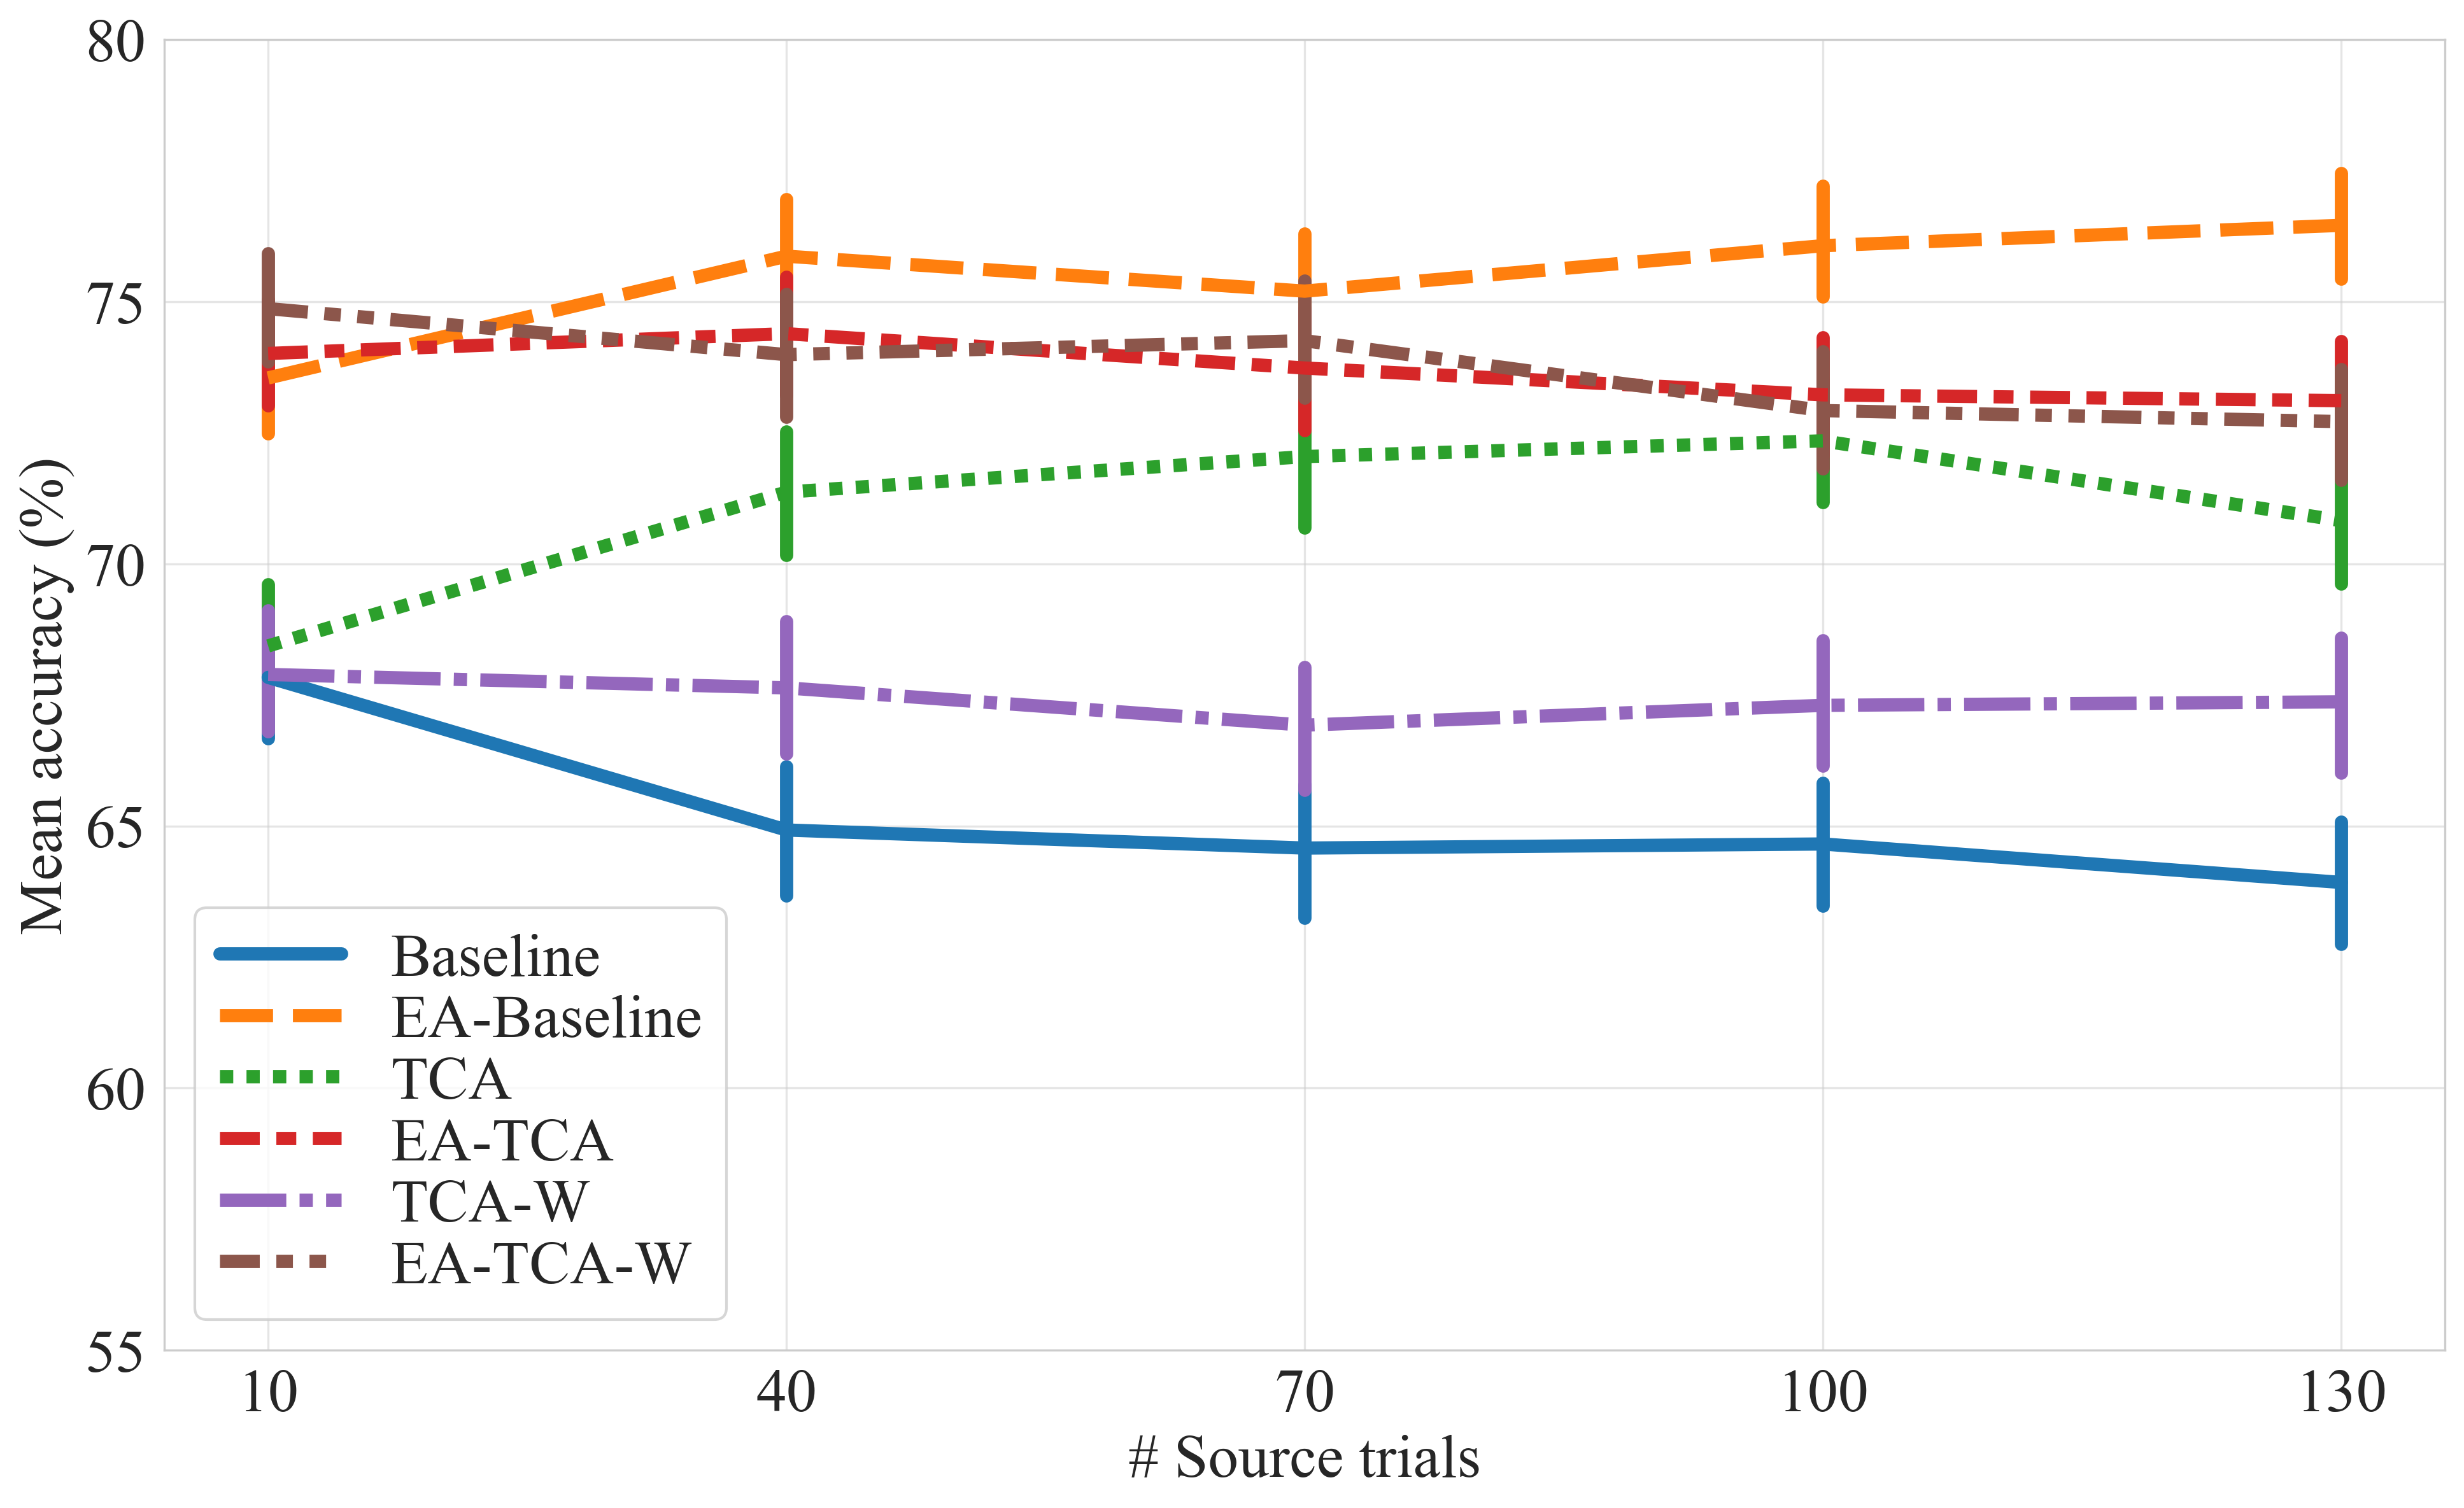

In [33]:
# Define necessary variables
figure_size = (13, 8)
font_size   = 23
df = df_src_acc

# Plotting
fig, ax = plt.subplots(figsize=figure_size, dpi=300)

# Dict to update error bar
error_kw=dict(lw=5)

ax = sns.lineplot(x='n_src', y='score', hue='method', data=df, style='method', linewidth=5, err_style="bars", ci=68, err_kws=error_kw)
ax.set_xticks(n_source)
ax.set_yticks(np.arange(55, 81, step=5))
ax.set_xlabel('# Source trials', fontsize = font_size)
ax.set_ylabel('Mean accuracy (%)', fontsize = font_size)
[tick.label.set_fontsize(font_size) for tick in ax.xaxis.get_major_ticks()]
[tick.label.set_fontsize(font_size) for tick in ax.yaxis.get_major_ticks()]

handles, labels = ax.get_legend_handles_labels()
# labels = ['Baseline', 'EA-Baseline', 'TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']

leg = ax.legend(handles, labels, loc='lower left', fontsize=font_size, markerscale=100, labelspacing=0.1)
[line.set_linewidth(5) for line in leg.get_lines()]

ax.grid(axis='both', alpha=.5)
fig.tight_layout()
# plt.savefig('src-acc-psfont.eps')
# plt.savefig('ppt-src-acc.png')
plt.show()

## `n-dim-tca` vs `acc`
**Goal**: Whether the dimensionality of tca space could affect accuracy?

**Concern:**: 
* Range of dimension? for now 1 to n-dim original
* The method that use tca-dim are CSP-TCA-SVM and EA-CSP-TCA-SVM

In [213]:
%%capture
# Iterate each subject over different dimension
tcadim_sc = {}
data = TL_data
n_iter    = 20
models  = ['TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']
csp_dim = TL_data['src'][1]['all_feats'].shape[1]
ndims = range(1, csp_dim+1)
# ndims = [5, 10, 15, 20, 30]

for m in models:
    tcadim_sc[m] = {}
    
    for t in TL_data['tgt'].keys():
        tcadim_sc[m][t] = {}
        
        # Modify tca dimension from 1 to max of csp features
        for dim in ndims:
            print(dim)
            tcadim_sc[m][t][dim] = []
            
            for i in range(n_iter):
                print(f'Iteration {i+1}')
                sc, _, _ = eval_all_ver7(data, tgt_subj=t, model=m, tca_ker='rbf', \
                                    tca_dim=dim, svm_ker='linear', n_tgt1=30, n_tgt2=50, n_sim=3, n_src=30)
                tcadim_sc[m][t][dim].append(sc)

In [214]:
# Creating long-format data
df_tcadim_acc = pd.DataFrame()

# Iterate over all models and subjects
for m in models:
    df_all_subj = pd.DataFrame()
    
    for t in TL_data['tgt'].keys():
        temp_df = pd.DataFrame(tcadim_sc[m][t])
        temp_df['model']  = m
        temp_df['subj'] = t
        temp_df.index.name   ='iter'
        temp_df.columns.name ='ndim'
        temp_df = temp_df.melt(id_vars=['subj', 'model'], value_vars=ndims, value_name='acc', var_name='ndim', ignore_index=False)
        
        # Concatenate all subject
        df_all_subj = pd.concat([df_all_subj, temp_df])
    
    # Concatenate all models
    df_tcadim_acc = pd.concat([df_tcadim_acc, df_all_subj])

In [37]:
# === Save to excel === #
fname = 'df_tcadim_acc.xlsx'
fpath = os.path.join('excel', fname)

if not os.path.isfile(fpath):
    print(f'saving {fname} ...')
    df_tcadim_acc.to_excel(fname, index=True, header=True)
else:
    print(f'{fname} already exist')

df_tcadim_acc.xlsx already exist


In [95]:
# === Load from excel === #
df_tcadim_acc = pd.read_excel('excel/df_tcadim_acc-v2.xlsx', index_col=0)

In [102]:
# Mean accuracy of each four methods for different dim
data = df_tcadim_acc.groupby(['model', 'ndim'])['acc'].mean().to_frame()

# Reset current model and ndim index as column, then pivot them
data = data.reset_index(level=["model", "ndim"])
data = data.pivot(index=['ndim'], columns=['model'], values='acc')

# Rearrange columns and 
data = data[['TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']]
data.loc[:, 'mean'] = data.mean(axis=1)
data

model,TCA,EA-TCA,TCA-W,EA-TCA-W,mean
ndim,,,,,
1,55.388889,63.533333,64.644444,69.455556,63.255556
2,69.144444,74.622222,68.266667,74.300000,71.583333
3,70.144444,73.722222,68.133333,74.977778,71.744444
4,70.644444,74.655556,69.144444,74.600000,72.261111
5,70.222222,73.866667,69.100000,74.911111,72.025000
6,70.333333,73.933333,69.111111,74.933333,72.077778


## `ker-type` vs `acc`
**Goal**: Finding the best pair SVM kernel and TCA kernel, does it affect the accuracy?

**Note:**: 
* Select n-dim = 4
* Do I have to set kernel in svm classifier as well?

In [147]:
%%capture
# Iterate each subject over different dimension
ker_sc    = {}
n_iter    = 20
models    = ['TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']
kernels   = ['linear', 'rbf']
# kernels   = ['linear', 'rbf']
tca_dim   = 4
data      = TL_data

for m in models:
    ker_sc[m] = {}
    
    for t in TL_data['tgt'].keys():
        ker_sc[m][t] = {}
        
        # Iterate over kernels for svm
        for svm_k in kernels:
            ker_sc[m][t][f'svm-{svm_k}'] = {}
        
            # Iterate over kernels for tca
            for tca_k in kernels:
                ker_sc[m][t][f'svm-{svm_k}'][f'tca-{tca_k}'] = []
                
                for i in range(n_iter):
                    sc, _, _ = eval_all_ver7(data, tgt_subj=t, model=m, tca_ker=tca_k, tca_dim=tca_dim, svm_ker=svm_k, n_tgt1=30, n_tgt2=50, n_sim=3, n_src=30)
                    
                    ker_sc[m][t][f'svm-{svm_k}'][f'tca-{tca_k}'].append(sc)

In [149]:
# === Creating DataFrame Combination of TCA kernel and SVM kernel === #
df_ker_acc = pd.DataFrame()
for m in models:
    df_all_subj = pd.DataFrame()
    for s in range(1, 10):
        df_all_svm_k = pd.DataFrame()
        for svm_k in ker_sc[m][s].keys():
            df_one_subj_svm = pd.DataFrame(ker_sc[m][s][svm_k])
            df_one_subj_svm.index.name = 'iter'
            df_one_subj_svm.columns.name = 'tca-kern'
            df_one_subj_svm['svm-kern'] = svm_k
            df_one_subj_svm['model'] = m
            df_one_subj_svm['subj'] = s
            df_one_subj_svm = df_one_subj_svm.melt(id_vars=['subj', 'svm-kern', 'model'], value_vars=['tca-linear', 'tca-rbf'], \
                                                   var_name=['tca-kern'], value_name='acc', ignore_index=False)
            
            # Concat all svm kernel
            df_all_svm_k = pd.concat([df_all_svm_k, df_one_subj_svm])

        # Concat over all subject
        df_all_subj = pd.concat([df_all_subj, df_all_svm_k])

    # Concat over all models
    df_ker_acc = pd.concat([df_ker_acc, df_all_subj])

In [115]:
# === Save to excel === #
fname = 'df_ker_acc.xlsx'
fpath = os.path.join('excel', fname)

if not os.path.isfile(fpath):
    print(f'saving {fname} ...')
    df_ker_acc.to_excel(fname, index=True, header=True)
else:
    print(f'{fname} already exist')

df_ker_acc.xlsx already exist


In [34]:
# ==== Load from excel ==== #
df_ker_acc = pd.read_excel('excel/df_ker_acc.xlsx', index_col=0, engine='openpyxl')
df_ker_acc.head()

,subj,svm-kern,model,tca-kern,acc
iter,,,,,
0,1,svm-linear,TCA,tca-linear,64.0
1,1,svm-linear,TCA,tca-linear,70.0
2,1,svm-linear,TCA,tca-linear,62.0
3,1,svm-linear,TCA,tca-linear,68.0
4,1,svm-linear,TCA,tca-linear,64.0


In [37]:
# Setting font size
SMALL  = 8
MEDIUM = 12
LARGE  = 15

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=LARGE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=LARGE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LARGE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [113]:
# Changing font family
sns.set_style("whitegrid",
              {'font.family':'Times New Roman', 'font.serif':'Times New Roman'})

In [4]:
# == Avoid type 3 font when submitting paper ===

import matplotlib as mpl
from matplotlib import rcParams
# mpl.rc_file_defaults()
# mpl.rcParams.update(mpl.rcParamsOrig)
# mpl.rcParams.update(mpl.rcParamsDefault)
# rcParams['figure.facecolor'] = 'white'
# rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
# rcParams['font.family'] = 'Times New Roman'
# rcParams['font.serif'] = 'Times New Roman'
# rcParams['text.usetex'] = True


# rcParams['ps.useafm'] = True
# rcParams['pdf.use14corefonts'] = True
# rcParams['text.usetex'] = True

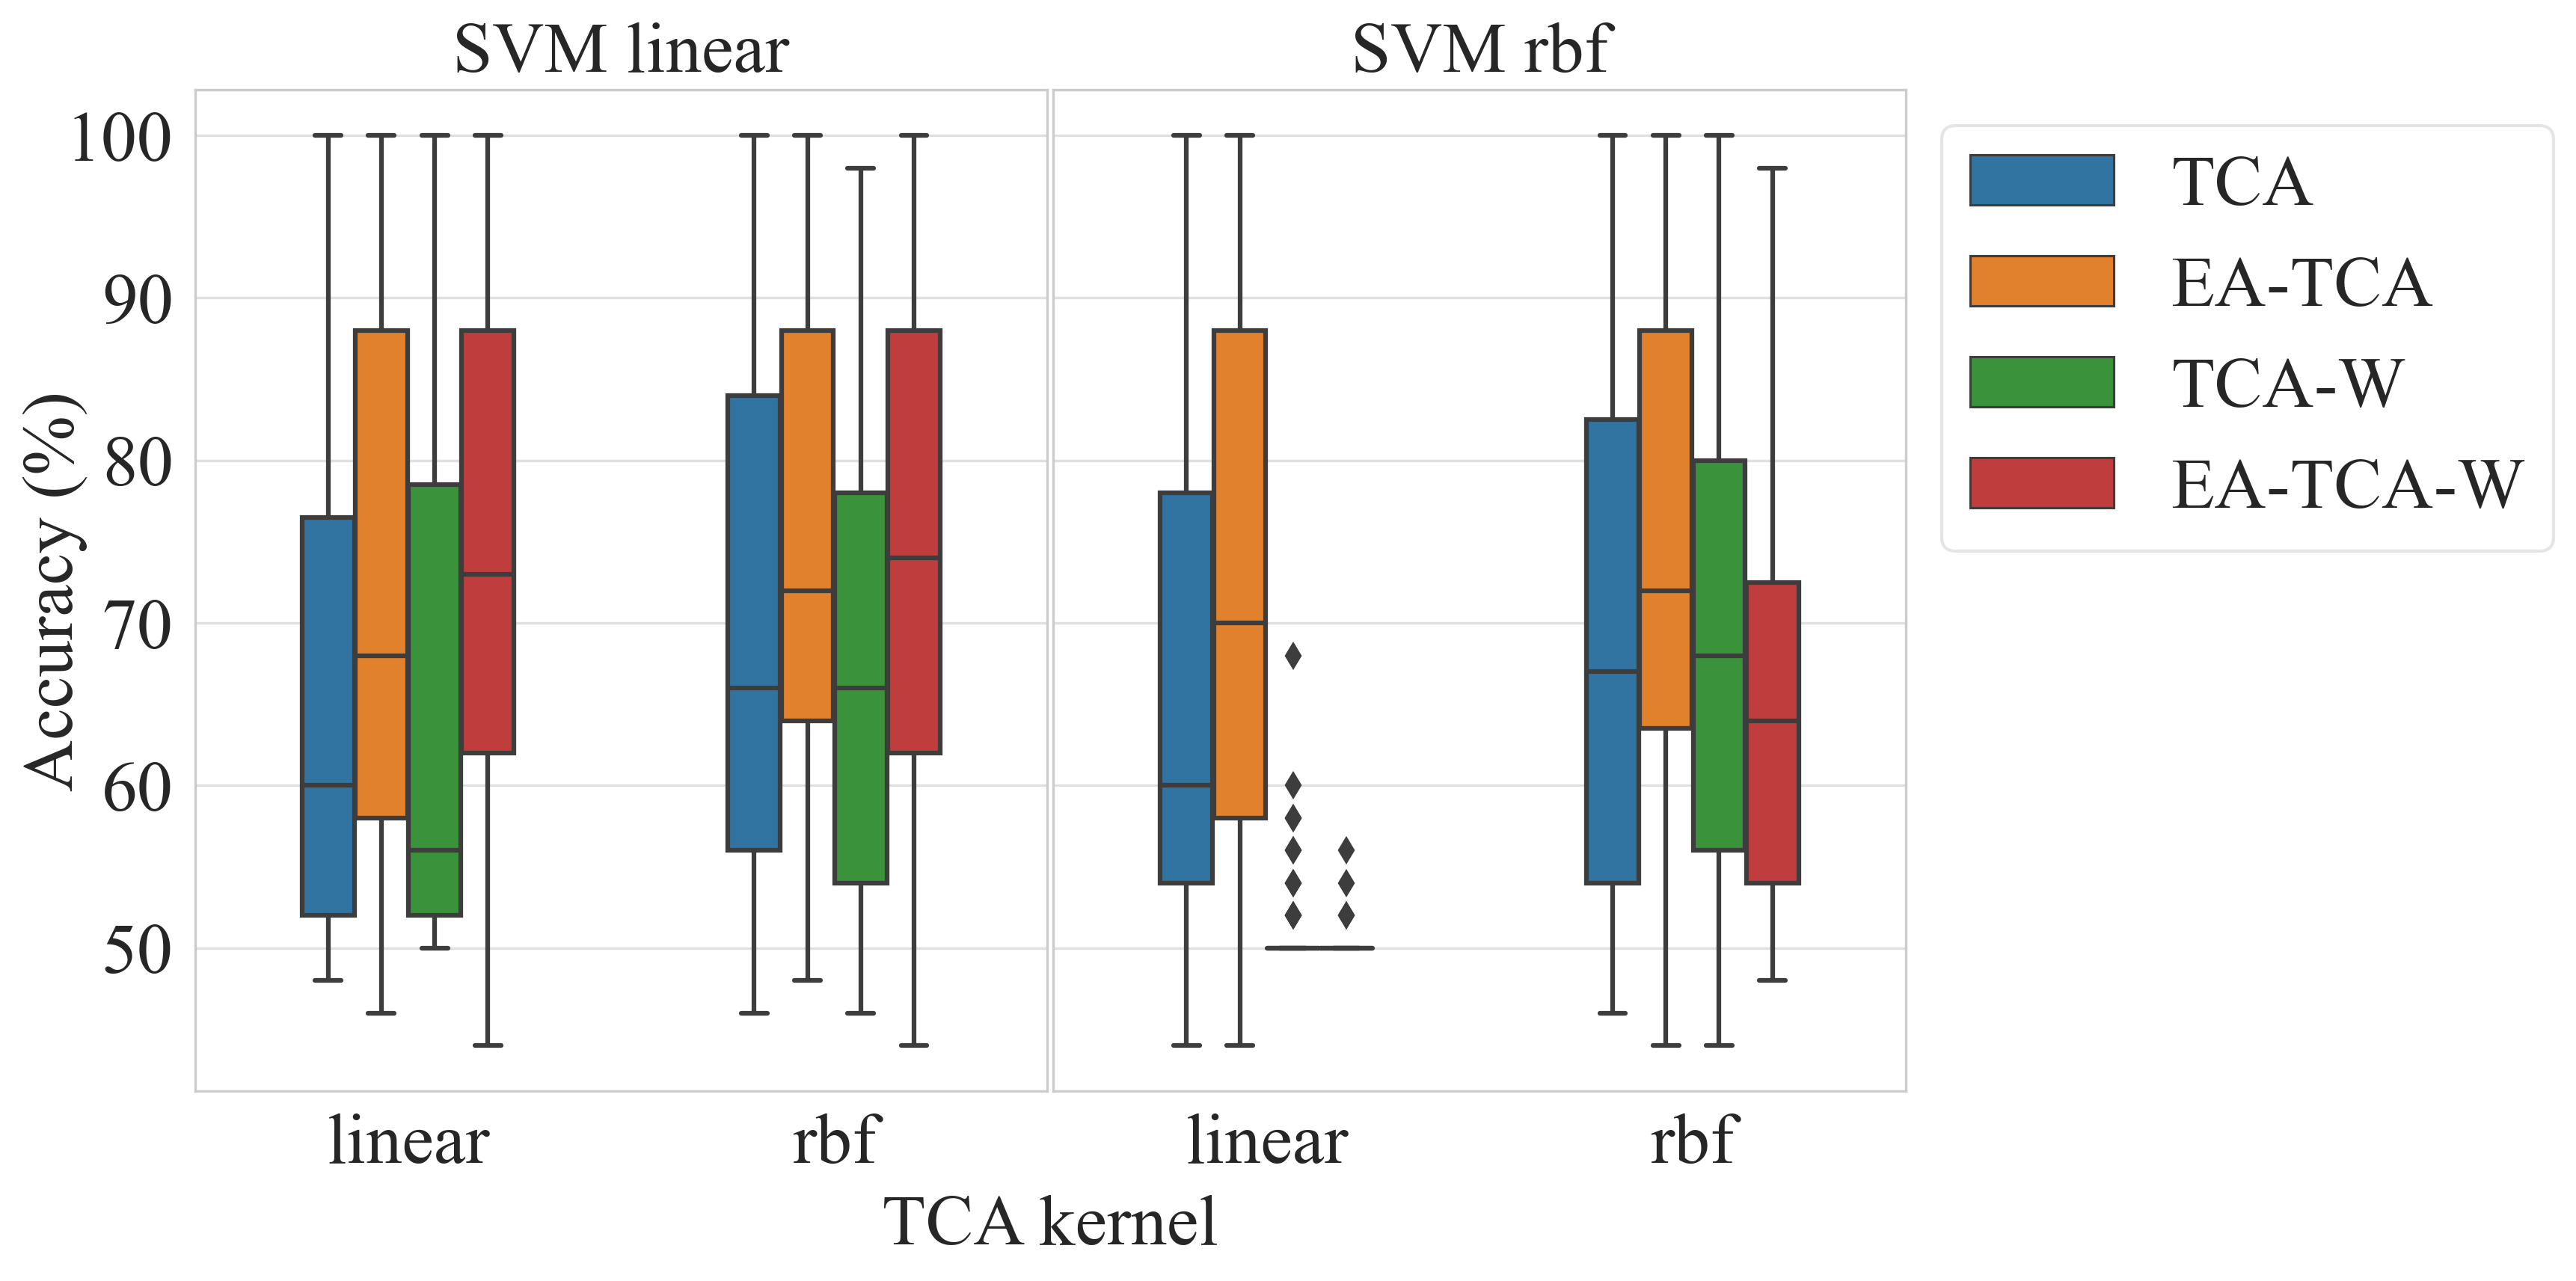

In [35]:
# Variable
nrow = 1
ncol = 2
figure_size = (12, 6)
kernels   = ['linear', 'rbf']
data = df_ker_acc
font_size = 23

# Plot
fig, axes = plt.subplots(nrow, ncol, figsize=figure_size, dpi=300, sharey=True)
fig.add_subplot(111, frameon=False)

# Custom palette
models = df_ker_acc['model'].unique()
colors = ['#21a1eb', '#edc337', '#a73fe8', '#ed3251']
my_palette = my_palette = {k:v for k,v in zip(models, colors)}

for kern, ax, in zip(kernels, axes.ravel()):
    svm_kern_val = f'svm-{kern}' 
    # print(svm_kern_val)
    ax.set_title(f'SVM {kern}', fontsize=font_size)
    ax.grid(axis='y', alpha=.6)
    ax.set_axisbelow(True)
    sns.boxplot(x='tca-kern', y='acc', hue='model', data=data[data['svm-kern'] == svm_kern_val], width=0.5, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.set(ylabel='', xlabel='', xticklabels=kernels)
    
    [tick.label.set_fontsize(font_size) for tick in ax.xaxis.get_major_ticks()]
    [tick.label.set_fontsize(font_size) for tick in ax.yaxis.get_major_ticks()]

ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 1), framealpha=0.5, fontsize=font_size)
plt.tick_params(axis='both', which='both', labelcolor='none', bottom=False, left=False)
plt.grid(False)
plt.xlabel('TCA kernel', fontsize=font_size, labelpad=17)
plt.ylabel('Accuracy (%)', fontsize=font_size, labelpad=15)
fig.tight_layout(pad=0.2)
# plt.savefig('ker-acc-psfont.eps')
# plt.savefig('ppt-acc-kern.png', bbox_inches='tight')
plt.show()

## time elapsed between `TCA` vs `TCA-W`
Measure time taken to process TCA and TCA-W

In [36]:
def process_TCA(Xraw_s, Ys, Xraw_t, Yt):
    '''
    Compute the TCA of CSp features
    '''
    # Extract CSP feats
    csp_src, csp_target = csp_feat_ver1(Xraw_s, Xraw_t, Ys)

    #print(csp_src.shape)
    #print(csp_target.shape)
    
    # Perform TCA
    tca = TCA(kernel_type='rbf', dim=4, svm_kernel='linear')
    
    acc, _, _, _ = tca.fit_predict(csp_src, Ys, csp_target, Yt)
    
    return acc

In [37]:
def time_process_TCA(data, tgt_subj=1, src_subj=3, isEA = True, n_src = 30, n_tgt2 = 50):
    '''
    data, tgt_subj, src_subj, isEA, n_src, n_tgt1, n_tgt2
    '''
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]

    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    ## Following models need to fetch source EA data
    # model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']

    # === EA data ====
    if isEA:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat_key = 'all_feats_EA'

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat_key = 'all_feats'

    # =============== RAW SOURCE DATA ============== #
    Xraw_src = deepcopy(data['src'][src_subj][key])
    y_src    = deepcopy(data['src'][src_subj]['y'])

    # ===== N random source sample ==== #
    idx = random.sample(range(len(Xraw_src)), n_src)
    while (y_src[idx] == 1).sum() != n_src//2:
        idx = random.sample(range(len(Xraw_src)), n_src)

    Xraw_src = Xraw_src[idx]
    y_src    = y_src[idx]

    # =============== RAW TARGET DATA ============== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])

    # ===== N random target2 sample ==== #
    # == Target 2 == #
    idx = random.sample(range(len(Xraw_tgt)), n_tgt2)
    while (y_tgt[idx] == 1).sum() != n_tgt2//2:
        idx = random.sample(range(len(Xraw_tgt)), n_tgt2)

    Xraw_tgt2 = Xraw_tgt[idx]
    y_tgt2    = y_tgt[idx]

    #print(Xraw_src.shape)
    #print(Xraw_tgt2.shape)

    acc = process_TCA(Xraw_src, y_src, Xraw_tgt2, y_tgt2)
    
    return acc

In [38]:
# Quick check the above function
time_process_TCA(TL_data, tgt_subj=1, src_subj=3, isEA = True, n_src = 30, n_tgt2 = 50)

0.88

In [39]:
def time_process_TCA_W(data, tgt_subj=1, src_subj=3, isEA = True, n_src=30, n_tgt1=30, n_tgt2=50, n_iter=20):
    '''
    data, tgt_subj, src_subj, isEA, n_src, n_tgt1, n_tgt2
    '''
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]

    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    ## Following models need to fetch source EA data
    # model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']

    # === EA data ====
    if isEA:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat_key = 'all_feats_EA'

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat_key = 'all_feats'
    
    # === GET SOURCE AND TARGET DATA 1 ONLY ONCE === #
    # =============== RAW SOURCE DATA ============== #
    Xraw_src = deepcopy(data['src'][src_subj][key])
    y_src    = deepcopy(data['src'][src_subj]['y'])

    # ===== N random source sample ==== #
    idx = random.sample(range(len(Xraw_src)), n_src)
    while (y_src[idx] == 1).sum() != n_src//2:
        idx = random.sample(range(len(Xraw_src)), n_src)

    Xraw_src = Xraw_src[idx]
    y_src    = y_src[idx]

    # =============== RAW TARGET DATA ============== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])
    
    # ===== N random target1 and target2 sample ==== #
    # == Target 1 ==
    idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    while (y_tgt[idx] == 1).sum() != n_tgt1//2:
        idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    
    # == Target 1 == #
    Xraw_tgt1 = Xraw_tgt[idx]
    y_tgt1    = y_tgt[idx]
    
    Xraw_tgt_left = np.delete(Xraw_tgt, idx, axis=0)
    y_tgt_left    = np.delete(y_tgt, idx, axis=0)
    
    
    # === Perform TCA with SOURCE and TARGET 1 DATA == #
    # Extract CSP features
    csp_src, csp_target1 = csp_feat_ver1(Xraw_src, Xraw_tgt1, y_src)
    
    #print(csp_src.shape)
    #print(csp_target1.shape)

    print('=== Building W and clf ===')
    
    # TCA, perform only once to build W and clf
    tca = TCA(kernel_type='rbf', dim=4, svm_kernel='linear')
    _, _, _, _ = tca.fit_predict(csp_src, y_src, csp_target1, y_tgt1)
    
    
    all_acc = []
    
    for n in range(n_iter):
        # =========== GET TARGET DATA 2 ========= #
        # == Target 2 == #
        idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
        while (y_tgt_left[idx] == 1).sum() != n_tgt2//2:
            idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)

        Xraw_tgt2 = Xraw_tgt_left[idx]
        y_tgt2    = y_tgt_left[idx]
        
        # CSP features
        _, csp_target2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src)
        
        acc, _, _, _ = tca.fit_predict_new(csp_target2, y_tgt2)
        all_acc.append(acc)
        
    return all_acc

In [40]:
# Quick check above function
acc = time_process_TCA_W(TL_data, tgt_subj=3, src_subj=1, isEA = True, n_src=30, n_tgt1=30, n_tgt2=50, n_iter=20)
print('All acc : ', acc)
print('Mean acc: ', np.mean(acc))

=== Building W and clf ===
All acc :  [0.96, 0.92, 0.96, 0.98, 0.94, 0.94, 0.9, 0.9, 0.94, 0.9, 0.92, 0.94, 0.94, 0.88, 0.86, 0.94, 0.92, 0.92, 0.94, 0.9]
Mean acc:  0.925


In [41]:
# Compute time elapsed between TCA and TCA-W
from time import time

In [46]:
n_iter = 20
target_sub = 6
source_sub = 8

print(f'===== Transferring from subject {target_sub} to subject {source_sub} =====')
# ===== TCA ===== #
stime_tca = time()
all_acc_tca = []

for i in range(n_iter):
    acc_tca = time_process_TCA(data=TL_data, tgt_subj=target_sub, src_subj=source_sub, n_src=30, n_tgt2=50)
    all_acc_tca.append(acc_tca)

etime_tca = time()


# ==== TCA-W ==== #
stime_tca_w = time()

all_acc_tca_w = time_process_TCA_W(data=TL_data, tgt_subj=target_sub, src_subj=source_sub, n_src=30, n_tgt1=30, n_tgt2=50, n_iter=n_iter)

etime_tca_w = time()

# == Compute time elapse for both methods == #
time_tca   = etime_tca - stime_tca
time_tca_w = etime_tca_w - stime_tca_w

print('===== TCA =====')
print(f'Elapsed time: {time_tca:.3f}s')
print(f'Mean acc: {np.array(all_acc_tca).mean():3f}')

print('===== TCA-W =====')
print(f'Elapsed time: {time_tca_w:.3f}s')
print(f'Mean acc: {np.array(all_acc_tca_w).mean():3f}')

print('')
print(f'Approximate time saves with respect to TCA {(time_tca - time_tca_w)/time_tca*100:.3f} %')

===== Transferring from subject 6 to subject 8 =====
=== Building W and clf ===
===== TCA =====
Elapsed time: 0.690s
Mean acc: 0.673000
===== TCA-W =====
Elapsed time: 0.320s
Mean acc: 0.660000

Approximate time saves with respect to TCA 53.616 %


----------------

# Misc. (Preliminary Results/Other) 

## `evaluate-all` function 8
**Main idea** :   
Found out about how to do update on incremental data, this class will caters about that as well.
Main difference with function 7 is here, all source will be merge as one big source, thus we don't  
need to compute mmd to determine best similar source to current target

The following method will be evaluate:
- CSP-SVM
- EA-CSP-SVM
- CSP-TCA-SVM
- EA-CSP-TCA-SVM

**Pseudocode**:
1. Function `eval_all_ver8` will accept the following parameter:
    - data    : data consisting of source and target
    - tgt_subj: subject act as target data
    - model   : model to be evaluated
    - tca_ker : kernel of tca
    - tca_dim : dim of tca
    - svm_ker : kernel of svm
    - n_tgt1  : random n sample of xt1
    - n_tgt2  : random n sample of xt2
    - n_src   : random n sample of src
    
    
2. Function `eval_all_ver8` will do the following:
    - Xt_raw, Yt : raw data choose whether ori or EA-ed data
    - Xt1, Xt2 : random n target sample, stratify Yt
    - Xs : random n source sample, stratify Ys
    - evaluate specified model
<!--     - csp_xt2 = csp(Xt2, Yt2),csp_xt1 = csp(Xt1, Yt1) -->
<!--     - csp_xs of all subjects -->
<!--     - distance, MMD of csp_xt1 to all csp_xs -->
<!--     - distance, MMD of csp_xt2 to all csp_xs -->

In [27]:
import random
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from func.csp_matlab import csp_feat_no_test_2

In [ ]:
ModelSVM()

In [62]:
def eval_all_ver8(data, tgt_subj=1, model='CSP-TCA-SVM', tca_ker='linear',\
                  tca_dim=3, svm_ker='linear', n_tgt1=20, n_tgt2=30, n_src=200):
    
    print(f'Processing target subject: {tgt_subj}')
    print(f'Model: == {model} ==') 
    
    # Key to define where data is stored
    all_keys=['epochs', 'epochs_EA', 'y']
    key_noEA = all_keys[0]
    key_EA = all_keys[1]    
    y = all_keys[2]
    
    # =========== PREPROCESSING  ============== #
    '''
    This section will fetch raw data to be evaluated
    '''
    ## Following models need to fetch source EA data
    # model_EA = ['EA-CSP-TCA-SVM', 'EA-CSP-SVM']
    
    # === EA data ====
    if 'EA' in model:
        # Set key variable in which EA data is stored
        key = key_EA
        csp_feat_key = 'all_feats_EA'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')

    # === no EA ===
    else:
        # Set key variable in which non-EA data is stored
        key = key_noEA
        csp_feat_key = 'all_feats'
        print(f'Fetching raw data stored in {key} csp_feat in {csp_feat_key}')
    
    # ============== RAW TARGET DATA =============== #
    Xraw_tgt = deepcopy(data['tgt'][tgt_subj][key])
    y_tgt    = deepcopy(data['tgt'][tgt_subj]['y'])
    
    # ===== N random target1 and target2 sample ==== #
    # == Target 1 == #
    idx = random.sample(range(len(Xraw_tgt)), n_tgt1)
    while (y_tgt[idx] == 1).sum() != n_tgt1//2:
        idx = random.sample(range(len(Xraw_tgt)), n_tgt1)

    Xraw_tgt1 = Xraw_tgt[idx]
    y_tgt1    = y_tgt[idx]
    
    Xraw_tgt_left = np.delete(Xraw_tgt, idx, axis=0)
    y_tgt_left    = np.delete(y_tgt, idx, axis=0)
    
    # == Target 2 == #
    idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
    while (y_tgt_left[idx] == 1).sum() != n_tgt2//2:
        idx = random.sample(range(len(Xraw_tgt_left)), n_tgt2)
        
    Xraw_tgt2 = Xraw_tgt_left[idx]
    y_tgt2    = y_tgt_left[idx]
    
    # ================ RAW SOURCE DATA =============== #
    # Collecting source subjects
    src_subj = [s for s in data['src'].keys() if s != tgt_subj]
    
    # Stacking all source raw data
    Xraw_src = np.array([])
    y_src    = np.array([])
    
    for s in src_subj:
        Xraw_one_s = data['src'][s][key]
        y_one_s    = data['src'][s][y]

        Xraw_src   = np.concatenate([Xraw_src, Xraw_one_s], axis=0) if len(Xraw_src) else Xraw_one_s
        y_src      = np.concatenate([y_src, y_one_s], axis=0) if len(y_src) else y_one_s
        
    assert Xraw_src.shape[0] == 144*len(src_subj)
    assert y_src.shape[0] == 144*len(src_subj)
    
    # Pick n random source data
    Xraw_src, _, y_src, _ = train_test_split(Xraw_src, y_src, stratify=y_src, train_size=n_src) 
    
    assert len(Xraw_src) == len(y_src)

    # ================== EVALUATION ==================== #
    # Variable to store best score from similar source subject
    best_sc = 0
    
    # ======= CSP-SVM ======= #
    if model == 'Baseline' or model == 'EA-Baseline':
        print(f'Evaluating {model}')
        # CSP of Xraw_tgt2 with filter from Xraw_src 
        csp_src, csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)

        # Perform SVM
        svm        = ModelSVM(kernel=svm_ker, coef=1)
        temp_sc    = svm.fit_predict(csp_src, y_src, csp_tgt2, y_tgt2)[0]

        best_sc = temp_sc if temp_sc > best_sc else best_sc
            
    # ==== CSP-TCA-SVM-B ==== # 
    if model == 'TCA' or model == 'EA-TCA':
        print(f'Evaluating {model}')

        # CSP of Xraw_tgt2 with filter from Xraw_src 
        csp_src, csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
        
        # Perform TCA
        tca       = TCA(kernel_type=tca_ker, dim=tca_dim, svm_kernel=svm_ker, lamb=1, gamma=1, coef=1, degree=3)
        temp_sc   = tca.fit_predict(csp_src, y_src, csp_tgt2, y_tgt2)[0]

        best_sc = temp_sc if temp_sc > best_sc else best_sc

    
    # ==== CSP-TCA-SVM-C ==== # 
    if model == 'TCA-W' or model == 'EA-TCA-W':
        print(f'Evaluating {model}')

        # CSP of Xraw_tgt1 and Xraw_tgt2 with filter from Xraw_src 
        csp_src, csp_tgt1 = csp_feat_ver1(Xraw_src, Xraw_tgt1, y_src, n_filter=3)
        _      , csp_tgt2 = csp_feat_ver1(Xraw_src, Xraw_tgt2, y_src, n_filter=3)
            
        # !! NOTICE csp_tgt1 is only to build W and clf in fit_preduct !!
        tca         = TCA(kernel_type=tca_ker, dim=tca_dim, svm_kernel=svm_ker, lamb=1, gamma=1, coef=1, degree=3)
        _, _, _, _  = tca.fit_predict(csp_src, y_src, csp_tgt1, y_tgt1)
        temp_sc     = tca.fit_predict_new(csp_tgt2, y_tgt2)[0]

        best_sc = temp_sc if temp_sc > best_sc else best_sc

    print('')
    return best_sc

In [72]:
%%capture
models = ['Baseline', 'EA-Baseline', 'TCA', 'EA-TCA', 'TCA-W', 'EA-TCA-W']
data = TL_data
n_iter = 20
tab_eval8 = {}

for m in models:
    print(m)
    tab_eval8[m] = {}
    model_sc = []

    for t in data['tgt'].keys():
        tab_eval8[m][t] = 0
        sub_sc = []
        
        for i in range(n_iter):
            print(f'Iteration {i+1}')
            sc = eval_all_ver8(data, tgt_subj=t, model=m, tca_ker='rbf', \
                               tca_dim=3, svm_ker='linear', n_tgt1=30, n_tgt2=50, n_src=200)
            sub_sc.append(sc)
            
        mean_sc, std_sc = np.array(sub_sc).mean(), np.array(sub_sc).std()
        model_sc.append(mean_sc)
        
        tab_eval8[m][t] = conv(mean_sc, std_sc)
    
    mean_sc, std_sc = np.array(model_sc).mean(), np.array(model_sc).std()
    tab_eval8[m]['avg'] = conv(mean_sc, std_sc)

In [71]:
# n_src=10, tca=rbf, svm=linear
pd.DataFrame(tab_eval8)

,Baseline,EA-Baseline,TCA,EA-TCA,TCA-W,EA-TCA-W
1,0.69 +/- 0.10,0.82 +/- 0.06,0.76 +/- 0.06,0.78 +/- 0.07,0.66 +/- 0.09,0.79 +/- 0.07
2,0.53 +/- 0.04,0.56 +/- 0.03,0.56 +/- 0.04,0.52 +/- 0.03,0.55 +/- 0.06,0.56 +/- 0.02
3,0.62 +/- 0.09,0.94 +/- 0.02,0.63 +/- 0.05,0.89 +/- 0.06,0.78 +/- 0.11,0.91 +/- 0.06
4,0.68 +/- 0.05,0.72 +/- 0.09,0.63 +/- 0.08,0.69 +/- 0.08,0.60 +/- 0.06,0.73 +/- 0.04
5,0.50 +/- 0.06,0.48 +/- 0.04,0.48 +/- 0.05,0.54 +/- 0.05,0.52 +/- 0.02,0.48 +/- 0.05
6,0.55 +/- 0.02,0.70 +/- 0.04,0.58 +/- 0.08,0.65 +/- 0.05,0.51 +/- 0.04,0.64 +/- 0.07
7,0.59 +/- 0.04,0.69 +/- 0.09,0.70 +/- 0.07,0.71 +/- 0.03,0.62 +/- 0.08,0.67 +/- 0.05
8,0.74 +/- 0.19,0.84 +/- 0.07,0.86 +/- 0.09,0.85 +/- 0.02,0.80 +/- 0.11,0.94 +/- 0.02
9,0.73 +/- 0.10,0.72 +/- 0.07,0.76 +/- 0.06,0.71 +/- 0.05,0.62 +/- 0.15,0.77 +/- 0.04
avg,0.63 +/- 0.08,0.72 +/- 0.13,0.66 +/- 0.11,0.70 +/- 0.12,0.63 +/- 0.10,0.72 +/- 0.14
